## INITIALISATION

### IMPORTS

In [1]:
import ollama
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

### GLOBAL VARIABLES

In [2]:
action_df = pd.read_csv("df_csv/action_dataset.csv", header=0, sep=";").dropna(how='all')
with open('french_stop_words.txt', 'r') as f:
    STOP_WORDS = f.read().splitlines()

MODEL_NAME = 'aya'
ACTION_LABELS = action_df['action'].dropna().unique()
TEST_SENTENCES = action_df['assistant_sentence']
TEST_WORDS = None
N_DIM = 50

### FUNCTIONS

In [35]:
def embedding_func(text: str) -> np.ndarray:
    return np.array(ollama.embeddings(model=MODEL_NAME, prompt=text)['embedding'])

def cosine_similarity(a: np.ndarray, b: np.ndarray) -> float:
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

def get_save_embeddings(file_name: str, text_iterable: list):
    if os.path.exists(file_name):
        with open(file_name, 'rb') as f:
            embeddings = np.load(f)
    else:
        embeddings = np.array([embedding_func(sentence) for sentence in tqdm(text_iterable)])
        # save the embeddings
        with open(file_name, 'wb') as f:
            np.save(f, embeddings)
    
    return embeddings

def extract_vocabulary(text_iterable: list, stop_words: list = STOP_WORDS):
    if stop_words is None:
        stop_words = []
    vocabulary = set()
    for text in text_iterable:
        words = text.split()
        for word in words:
            if word not in stop_words:
                vocabulary.add(word)
    return vocabulary

def new_words(text:str, stop_words: list = STOP_WORDS) -> list:
    chars_to_replace_with_space = ['?', '!', '.', ',', ';', "'", '"']
    words = text.lower()
    for char in chars_to_replace_with_space:
        words = words.replace(char, ' ')
    words = words.split()
    return extract_vocabulary(words, stop_words)

def new_phrase(text:str, stop_words: list = STOP_WORDS) -> str:
    return ' '.join(new_words(text, stop_words))

def print_bad_predictions(y_test, y_pred, X_test, X):
    # print all bad predictions, sentence and label
    print("SHAPES", "-"*50)
    print(f"y_test: {y_test.shape}")
    print(f"y_pred: {y_pred.shape}")
    print(f"X_test: {X_test.shape}")
    print(f"X: {X.shape}")
    print("\nBAD PREDICTIONS", "-"*50)
    print("Sentence - True Label - Predicted Label")
    for i in range(len(y_pred)):
        if y_pred[i] != y_test.iloc[i]:
            # find index in X_pca where X_test[i] is
            try :
                index = np.where((X == X_test[i]).all(axis=1))[0][0]
                print(f"-  {TEST_SENTENCES.iloc[index]} - {y_test.iloc[i]} - {y_pred[i]}")
            except:
                print(f"Index {i} not found in X_pca, y_pred={y_test.iloc[i]}, y_test={y_pred[i]}")

def encode_y(y_str, dict_str_int):
    return np.array([dict_str_int[label] for label in y_str])

def decode_y(y_int, dict_int_str):
    return np.array([dict_int_str[label] for label in y_int])

In [4]:
print(embedding_func('The quick brown fox jumps over the lazy fog')) # test embedding function so the model is loaded

print(TEST_SENTENCES[0])
print(new_phrase(TEST_SENTENCES[0]))

[-7.38868952  5.99665213 -9.11465073 ... -1.09154022 12.75729847
  6.15325594]
Je vais t'envoyer ces informations par mail.
informations envoyer mail vais


In [5]:
sentences_words = TEST_SENTENCES.apply(new_words)
# count = {i : len(sentences_words[i]) for i in range(len(sentences_words))}

count = 0
dict_senteces_word_indexes = dict()
for i in range(len(sentences_words)):
    for j in range(len(sentences_words[i])):
        dict_senteces_word_indexes[count] = (i, j)
        count += 1

TEST_WORDS = np.array([word for words in sentences_words for word in words])

##### plot

In [6]:
def break_sentence_into_lines(sentence: str, max_line_length: int = 20) -> str:
    words = sentence.split()
    lines = []
    line = ''
    for word in words:
        if len(line) + len(word) + 1 <= max_line_length:
            line += word + ' '
        else:
            lines.append(line)
            line = word + ' '
    lines.append(line)
    return '\n'.join(lines)

def pretty_print_matrix(matrix: np.ndarray, num_spaces: int = 2):
    for row in matrix:
        for cell in row:
            if round(cell, 2) == 0:
                print('0   ', end=' ' * num_spaces)
            else:
                print(f'{cell:.2f}', end=' ' * num_spaces)
        print()

# plot the t-SNE
def plot_2D(X, ax):
    cmap = plt.colormaps.get_cmap('tab10')
    for i, action_label in enumerate(ACTION_LABELS):

        mask = action_df['action'] == action_label
        ax.scatter(X[mask, 0], X[mask, 1], alpha=0.7, label=action_label, color=cmap(i))

        x_mean = X[mask, 0].mean()
        y_mean = X[mask, 1].mean()
        name_str = break_sentence_into_lines(" ".join(action_label.split("_")).title(), max_line_length=20)

        ax.text(x_mean, y_mean, name_str, horizontalalignment='center', verticalalignment='center', fontsize=10, fontstyle='italic', fontweight='bold', bbox=dict(facecolor='white', alpha=0.4), color=cmap(i))

    # other data (action_label not in the list)
    mask = ~action_df['action'].isin(ACTION_LABELS)
    ax.scatter(X[mask, 0], X[mask, 1], alpha=0.7, label="other", color='grey')


def plot_confusion_matrix(y, y_pred, labels, french=True):

    c_matrix = np.array(confusion_matrix(y, y_pred, labels=labels))

    fig, ax = plt.subplots()
    cmap = plt.colormaps.get('Blues')
    cax = ax.matshow(c_matrix, cmap=cmap)
    max_val = c_matrix.max()
    min_val = c_matrix.min()
    # text
    for (i, j), val in np.ndenumerate(c_matrix):
        if val == min_val:
            continue
        bg_color = cmap((val - min_val) / (max_val - min_val))
        luminance = 0.299 * bg_color[0] + 0.587 * bg_color[1] + 0.114 * bg_color[2]
        text_color = 'black' if luminance > 0.5 else 'white'
        ax.text(j, i, f"{val}", ha='center', va='center', color=text_color)

    # insert \n in labels when too long
    each_n = 24

    def insert_newlines(string, every=30):
        words = string.split()
        # if the combined length of the words is less than the every parameter
        if len(' '.join(words)) < every:
            return ' '.join(words)
        
        # if the combined length of the words is greater than the every parameter
        new_string = ''
        current_length = 0
        for word in words:
            if current_length + len(word) > every:
                new_string += '\n'
                current_length = 0
            new_string += word + ' '
            current_length += len(word) + 1
        return new_string

    plt_labels = [labels[i] if len(labels[i]) < each_n else insert_newlines(labels[i], each_n) for i in range(len(labels))]
    if french:
        plt_labels = ['Inconnu' if label == 'Unknown' else label for label in plt_labels]

    ax.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)

    plt.xticks(range(len(labels)), range(len(labels)))
    plt.yticks(range(len(labels)), range(len(labels)))

    # text associating label number with label name
    for i in range(len(labels)):
        ax.text(len(labels), i, f"{i} - {plt_labels[i]}", ha='left', va='center', fontsize=10)

    ax.xaxis.set_label_position('top') 
    if french:
        plt.title('Matrice de confusion', pad=20, fontsize=15, fontweight='bold', color='black', y=-0.2)
        plt.xlabel('Action prédite')
        plt.ylabel('Action réelle')
    else:
        plt.title('Confusion matrix', pad=20, fontsize=15, fontweight='bold', color='black', y=-0.2)
        plt.xlabel('Predicted action')
        plt.ylabel('Actual action')
    plt.tight_layout()
    plt.show()

## COMPUTE EMBEDDINGS

In [7]:
action_embeddings = get_save_embeddings(f"embeddings/action_embeddings_{MODEL_NAME}.npy", ACTION_LABELS)

100%|██████████| 4/4 [00:00<00:00, 18.99it/s]


In [8]:
test_sentence_embeddings = get_save_embeddings(f"embeddings/test_sentence_embeddings_{MODEL_NAME}.npy", TEST_SENTENCES)

100%|██████████| 1927/1927 [02:50<00:00, 11.27it/s]


In [9]:
test_word_embeddings = get_save_embeddings(f"embeddings/test_word_embeddings_{MODEL_NAME}.npy", TEST_WORDS)

100%|██████████| 9536/9536 [05:25<00:00, 29.28it/s]


## COMPUTE PCA and TSNE

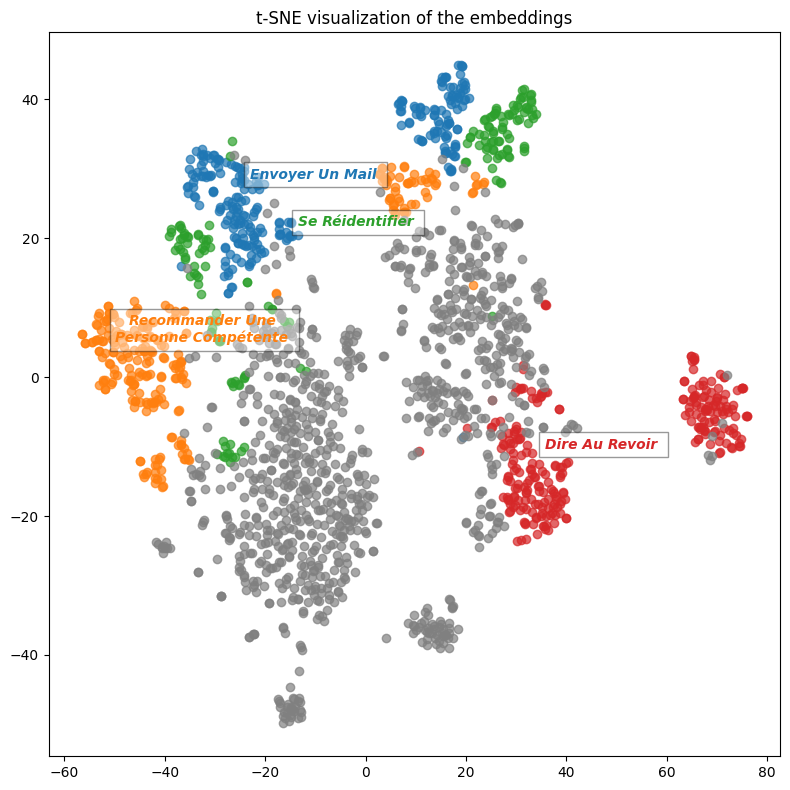

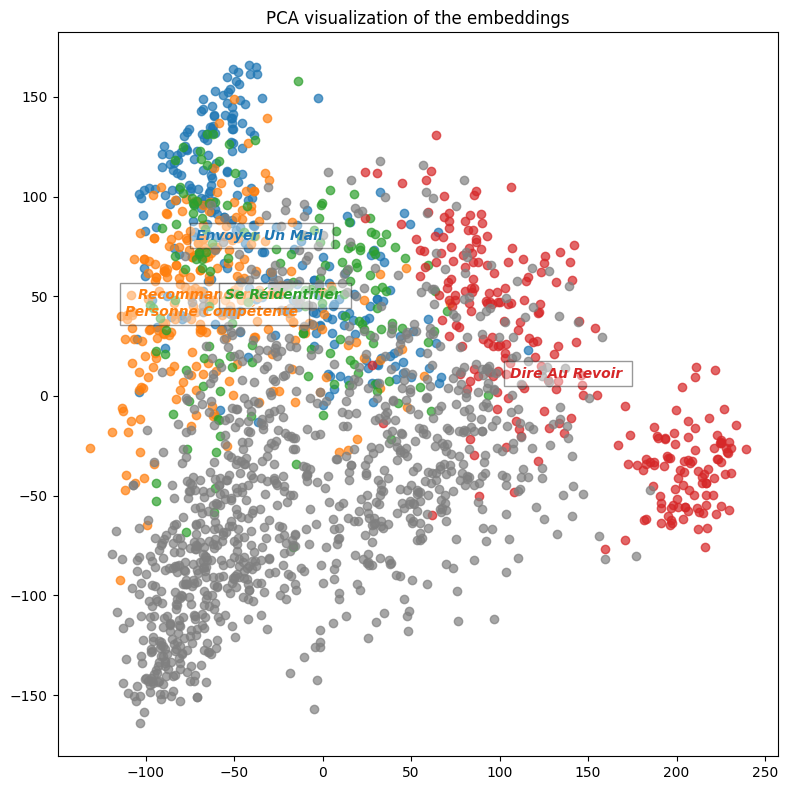

In [10]:
# tsne visualization of the embeddings

tsne = TSNE(n_components=2, random_state=0)
X_tsne = tsne.fit_transform(test_sentence_embeddings)

pca = PCA(n_components=2, random_state=0)
X_pca = pca.fit_transform(test_sentence_embeddings)


fig, ax = plt.subplots(figsize=(8, 8))
plot_2D(X_tsne, ax)
ax.set_title("t-SNE visualization of the embeddings")
plt.tight_layout()
plt.savefig("plots/tsne.png")
plt.show()


fig, ax = plt.subplots(figsize=(8, 8))
plot_2D(X_pca, ax)
ax.set_title("PCA visualization of the embeddings")
plt.tight_layout()
plt.savefig("plots/pca.png")
plt.show()


## CLASSIFICATION

### PREPROCESSING

In [27]:
test_sentence_similarity_file_name = f"embeddings/test_sentence_similarity_{MODEL_NAME}.npy"

if os.path.exists(test_sentence_similarity_file_name):
    with open(test_sentence_similarity_file_name, 'rb') as f:
        test_sentence_similarity = np.load(f)
else:
    test_sentence_similarity = np.array([[cosine_similarity(action_embedding, test_sentence_embedding) for test_sentence_embedding in test_sentence_embeddings] for action_embedding in action_embeddings])
    with open(test_sentence_similarity_file_name, 'wb') as f:
        np.save(f, test_sentence_similarity)

In [28]:
ponctuation_features = np.array([[(p in sentence) for p in ['.', ',', '?', '!']] for sentence in TEST_SENTENCES]).astype(float)

In [29]:
word_in_action_features = np.array([[np.mean([1 if (word in action) else 0 for word in words]) for action in ACTION_LABELS] for words in sentences_words]).astype(float)

C:\Users\echriston\AppData\Roaming\Python\Python311\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\echriston\AppData\Roaming\Python\Python311\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [30]:
tsne = TSNE(n_components=3, random_state=0)
X_tsne = tsne.fit_transform(test_sentence_embeddings)

pca = PCA(n_components=N_DIM, random_state=0)
X_pca = pca.fit_transform(test_sentence_embeddings)

In [31]:
print("SHAPES", "="*35)
print("  X_tsne                     ", X_tsne.shape)
print("  X_pca                      ", X_pca.shape)
print("  action_embeddings          ", action_embeddings.shape)
print("  test_sentence_embeddings   ", test_sentence_embeddings.shape)
print("  test_sentence_similarity   ", test_sentence_similarity.shape)
print("  ponctuation_features       ", ponctuation_features.shape)
print("  word_in_action_features    ", word_in_action_features.shape)

SHAPES ===================================
  X_tsne                      (1927, 3)
  X_pca                       (1927, 50)
  action_embeddings           (4, 4096)
  test_sentence_embeddings    (1927, 4096)
  test_sentence_similarity    (4, 1927)
  ponctuation_features        (1927, 4)
  word_in_action_features     (1927, 4)


In [33]:
X = np.concatenate([X_pca, test_sentence_similarity.T, word_in_action_features], axis=1)
scaler = StandardScaler()
X = scaler.fit_transform(X)
y_str = action_df['action']
# if y not in ACTION_LABELS, replace it with "Unknown"
# y = y.apply(lambda x: x if x in ACTION_LABELS else "Unknown")
y_str = y_str.fillna("Unknown")
y_str_unique = np.concatenate([ACTION_LABELS, ["Unknown"]])
dict_str_num = {label: i for i, label in enumerate(y_str_unique)}
dict_num_str = {i: label for i, label in enumerate(y_str_unique)}

X_train, X_test, y_train, y_test = train_test_split(X, y_str, test_size=0.2, random_state=0)

print("SHAPES", "="*15)
print("  X_train ", X_train.shape)
print("  X_test  ", X_test.shape)
print("  y_train ", y_train.shape)
print("  y_test  ", y_test.shape)

SHAPES ===============
  X_train  (1541, 58)
  X_test   (386, 58)
  y_train  (1541,)
  y_test   (386,)


### SIMILARITY

#### sentence to action

Accuracy: 0.54


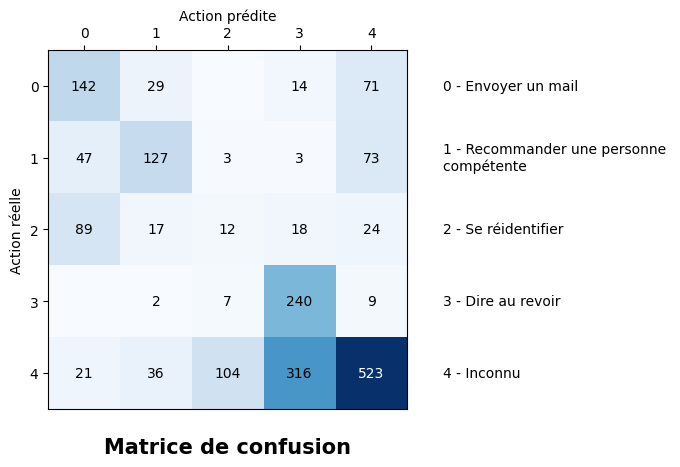

SHAPES --------------------------------------------------
y_test: (1927,)
y_pred: (1927,)
X_test: (1927, 58)
X: (1927, 58)

BAD PREDICTIONS --------------------------------------------------
Sentence - True Label - Predicted Label
-  Tu recevras ces infos par courrier électronique. - Envoyer un mail - Unknown
-  Je te fais suivre ça par e-mail. - Envoyer un mail - Unknown
-  Tu auras ces infos par e-mail très bientôt. - Envoyer un mail - Unknown
-  Attends-toi à recevoir ces détails par mail. - Envoyer un mail - Unknown
-  Je vais t'envoyer les infos par e-mail très bientôt. - Envoyer un mail - Unknown
-  Tu recevras un e-mail de ma part avec ces détails. - Envoyer un mail - Unknown
-  Je t'envoie ça par e-mail dans un instant. - Envoyer un mail - Unknown
-  Tu trouveras ces informations dans ton e-mail bientôt. - Envoyer un mail - Unknown
-  Je te transmets les détails par e-mail dès que possible. - Envoyer un mail - Unknown
-  Je te fais suivre un e-mail avec les détails. - Envoyer u

In [44]:
y_pred = np.array(np.argmax(test_sentence_similarity, axis=0))
# when similarity under threshold, predict y_pred = 0
threshold = 0.4
y_pred[np.max(test_sentence_similarity, axis=0) < threshold] = dict_str_num['Unknown']
y_pred_str = decode_y(y_pred, dict_num_str)

accuracy = (y_str == y_pred_str).mean()
print(f"Accuracy: {accuracy:.2f}")

# plot confusion matrix
plot_confusion_matrix(y_str, y_pred_str, y_str_unique)

# print bad predictions
print_bad_predictions(y_str, y_pred_str, X, X)

#### word to action

In [18]:
test_word_similarity_file_name = f"embeddings/test_word_similarity_{MODEL_NAME}.npy"

if os.path.exists(test_word_similarity_file_name):
    with open(test_word_similarity_file_name, 'rb') as f:
        test_word_similarity = np.load(f)
else:
    test_word_similarity = np.zeros((len(TEST_WORDS), len(ACTION_LABELS)))
    for i, word_embedding in tqdm(enumerate(test_word_embeddings)):
        for j, action_embedding in enumerate(action_embeddings):
            test_word_similarity[i, j] = cosine_similarity(word_embedding, action_embedding)
        
    with open(test_word_similarity_file_name, 'wb') as f:
        np.save(f, test_word_similarity)

9536it [00:00, 26786.32it/s]


100%|██████████| 9536/9536 [00:00<00:00, 206958.93it/s]

Accuracy: 0.56


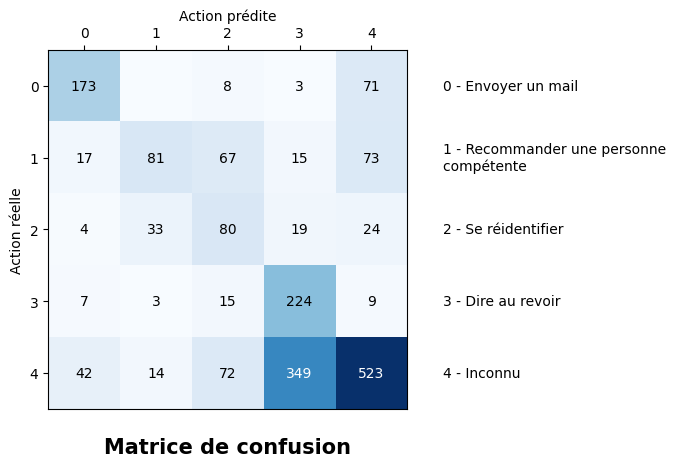

SHAPES --------------------------------------------------
y_test: (1927,)
y_pred: (1927,)
X_test: (1927, 58)
X: (1927, 58)

BAD PREDICTIONS --------------------------------------------------
Sentence - True Label - Predicted Label
-  Tu recevras ces infos par courrier électronique. - Envoyer un mail - Unknown
-  Je te fais suivre ça par e-mail. - Envoyer un mail - Unknown
-  Prépare-toi à recevoir un message électronique de ma part. - Envoyer un mail - Se réidentifier
-  Tu auras ces infos par e-mail très bientôt. - Envoyer un mail - Unknown
-  Attends-toi à recevoir ces détails par mail. - Envoyer un mail - Unknown
-  Je vais t'envoyer les infos par e-mail très bientôt. - Envoyer un mail - Unknown
-  Tu recevras un e-mail de ma part avec ces détails. - Envoyer un mail - Unknown
-  Je t'envoie ça par e-mail dans un instant. - Envoyer un mail - Unknown
-  Tu trouveras ces informations dans ton e-mail bientôt. - Envoyer un mail - Unknown
-  Je te transmets les détails par e-mail dès que 

In [36]:
# now we have the similarity between each word and each action
# we can sum the similarities of all the words in a sentence to get the similarity between the sentence and the action

test_sentence_similarity_sum = np.zeros((len(TEST_SENTENCES), len(ACTION_LABELS)))
for n_word, (n_sentence, n_word_in_sentence) in tqdm(dict_senteces_word_indexes.items()):
    test_sentence_similarity_sum[n_sentence] += test_word_similarity[n_word] / len(sentences_words[n_sentence])

y_pred = np.array(np.argmax(test_sentence_similarity_sum, axis=1))
threshold = 0.4
y_pred[np.max(test_sentence_similarity, axis=0) < threshold] = dict_str_num['Unknown']
y_pred_str = decode_y(y_pred, dict_num_str)
y_pred_str = decode_y(y_pred, dict_num_str)

accuracy = (y_str == y_pred_str).mean()
print(f"Accuracy: {accuracy:.2f}")

# plot confusion matrix
plot_confusion_matrix(y_str, y_pred_str, y_str_unique)

# print bad predictions
print_bad_predictions(y_str, y_pred_str, X, X)

### RANDOM FOREST

Training accuracy: 1.0
Test accuracy: 0.9559585492227979


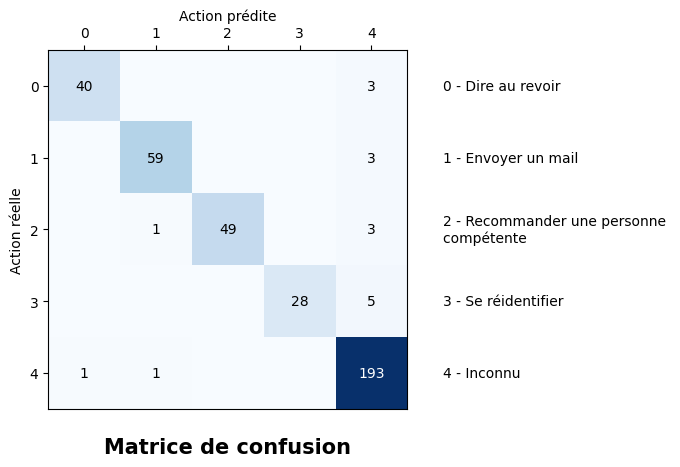

SHAPES --------------------------------------------------
y_test: (386,)
y_pred: (386,)
X_test: (386, 58)
X: (1927, 58)

BAD PREDICTIONS --------------------------------------------------
Sentence - True Label - Predicted Label
-  À plus tard ? - Dire au revoir - Unknown
-  Vérification de ton identité en cours. - Se réidentifier - Unknown
-  Prépare-toi à recevoir un message électronique de ma part. - Envoyer un mail - Unknown
-  La prochaine fois, on se retrouve pour de nouvelles aventures ? - Dire au revoir - Unknown
-  Je m'occuperai de te mettre en contact avec quelqu'un de compétent. - Recommander une personne compétente - Envoyer un mail
-  Recommençons le processus d'identification pour être certain. - Se réidentifier - Unknown
-  Lançons la réidentification. - Se réidentifier - Unknown
-  je suis disponible ces jours-là. - Unknown - Envoyer un mail
-  Allons dénicher le cerveau le plus brillant de notre organisation pour résoudre ce problème. - Recommander une personne compéte

In [45]:
clf = RandomForestClassifier(random_state=0)
clf.fit(X_train, y_train)

y_proba = clf.predict_proba(X_test)

y_pred = clf.predict(X_test)

y_pred = np.array([y_pred[i] if y_proba[i, clf.classes_ == y_pred[i]] > 0.0 else 'Unknown' for i in range(len(y_pred))])

test_accuracy = np.mean(y_pred == y_test)

print(f"Training accuracy: {clf.score(X_train, y_train)}")
print(f"Test accuracy: {test_accuracy}")

plot_confusion_matrix(y_test, y_pred, clf.classes_)

print_bad_predictions(y_test, y_pred, X_test, X)

### NEURAL NETWORK

C:\Users\echriston\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 16)             │           944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │            85 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,301 (5.08 KB)

 Trainable params: 1,301 (5.08 KB)

 Non-trainable params: 0 (0.00 B)

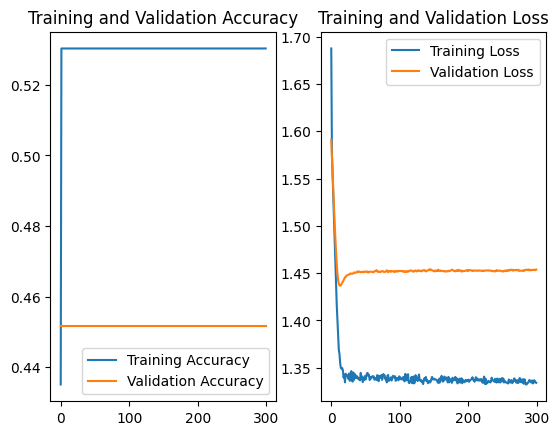

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
0.13    0.13    0.08    0.13    0.53    
0.13    0.13    0.08    0.13    0.53    
0.13    0.13    0.08    0.13    0.53    
0.13    0.13    0.08    0.13    0.53    
0.13    0.13    0.08    0.13    0.53    
0.13    0.13    0.08    0.13    0.53    
0.13    0.13    0.08    0.13    0.53    
0.13    0.13    0.08    0.13    0.53    
0.13    0.13    0.08    0.13    0.53    
0.13    0.13    0.08    0.13    0.53    
0.13    0.13    0.08    0.13    0.53    
0.13    0.13    0.08    0.13    0.53    
0.13    0.13    0.08    0.13    0.53    
0.13    0.13    0.08    0.13    0.53    
0.13    0.13    0.08    0.13    0.53    
0.13    0.13    0.08    0.13    0.53    
0.13    0.13    0.08    0.13    0.53    
0.13    0.13    0.08    0.13    0.53    
0.13    0.13    0.08    0.13    0.53    
0.13    0.13    0.08    0.13    0.53    
0.13    0.13    0.08    0.13    0.53    
0.13    0.13    0.08    0.13    0.53    
0.13    0.13    0.08    0.13    0.53    
0.13    0.13    0

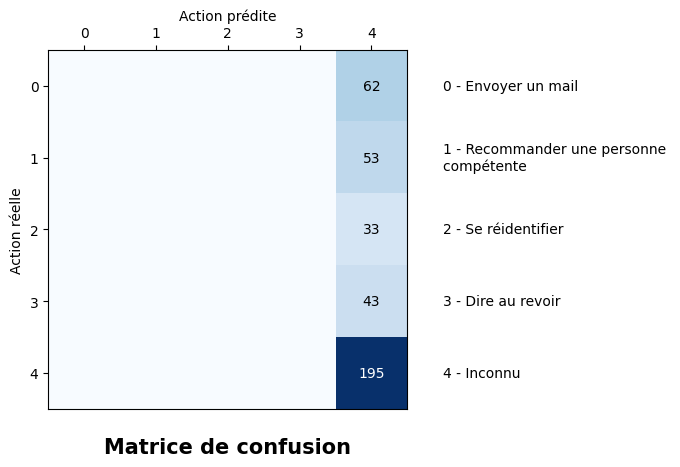


BAD PREDICTIONS --------------------------------------------------
Sentence - True Label - Predicted Label
-  À la prochaine ! - Dire au revoir - Unknown
-  Souhaites-tu recevoir ces détails par courriel ? - Envoyer un mail - Unknown
-  Au revoir, et bon courage ! - Dire au revoir - Unknown
-  Je vais te présenter à un collaborateur de l'entreprise qui peut t'aider. - Recommander une personne compétente - Unknown
-  Je vais te faire parvenir ces informations par courriel. - Envoyer un mail - Unknown
-  Je peux te les faire parvenir via courriel si c'est mieux pour toi. - Envoyer un mail - Unknown
-  À plus tard ? - Dire au revoir - Unknown
-  Je vais t'envoyer les infos par e-mail très bientôt. - Envoyer un mail - Unknown
-  Je peux te transmettre ces détails par mail si tu veux. - Envoyer un mail - Unknown
-  Je vais confirmer ton identité par une nouvelle vérification. - Se réidentifier - Unknown
-  Je te transmettrai ces informations par e-mail. - Envoyer un mail - Unknown
-  À plu

In [21]:
num_classes = len(y_str_unique)

model = Sequential([
    layers.Dense(16, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dropout(0.2),
    layers.Dense(16, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(0.0005),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

model.summary()

y_train_int = encode_y(y_train, dict_str_num)

epochs = 300
history = model.fit(X_train, y_train_int, epochs=epochs, validation_split=0.1, verbose=0)



acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure()
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()





y_pred_probas = model.predict(X_test)
# argmax if proba above threshold, else 'Unknown' (-100)
pretty_print_matrix(y_pred_probas, num_spaces=4)
y_pred_int = np.array([np.argmax(probas) if np.max(probas) > 0.3 else dict_str_num["Unknown"] for probas in y_pred_probas])
y_pred = decode_y(y_pred_int, dict_num_str)

test_accuracy = np.mean(y_pred == y_test)
print(f"Test accuracy: {test_accuracy}")

plot_confusion_matrix(y_test, y_pred, y_str_unique)

print_bad_predictions(y_test, y_pred, X_test, X)

In [22]:
# save the model
model.save(f"models/{MODEL_NAME}_model.h5")

## INFERENCE

In [23]:
# load the model
model = tf.keras.models.load_model(f"models/{MODEL_NAME}_model.h5")

# inference
sentence = "Parler"
sentence_embedding_large = embedding_func(sentence)
sentence_similarity = np.array([cosine_similarity(sentence_embedding_large, action_embedding) for action_embedding in action_embeddings]).reshape(1, -1)
sentence_embedding = pca.transform(sentence_embedding_large.reshape(1, -1))
ponctuation_features = np.array([[(p in sentence) for p in ['.', ',', '?', '!']]]).astype(float)
words = new_words(sentence)
word_in_action_features = np.array([[np.mean([1 if (word in action) else 0 for word in words]) for action in ACTION_LABELS]]).astype(float)

X = np.concatenate([sentence_embedding, sentence_similarity, word_in_action_features], axis=1)
X = scaler.transform(X)
y_proba = model.predict(X)
y_str = decode_y(np.argmax(y_proba, axis=1), dict_num_str)[0]
print("Action probas")
pretty_print_matrix(y_proba, num_spaces=4)
print(f"Sentence: {sentence}")
print(f"Action: {y_str}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Action probas
0.13    0.13    0.08    0.13    0.53    
Sentence: Parler
Action: Unknown
